# Lab 3: Genome-Wide Association Studies

### Due March 25, 2020 11:59 PM

#### Preamble (Don't change this)

## Important Instructions - 

1. Please implement all the *graded functions* in main.py file. Do not change function names in main.py.
2. Please read the description of every graded function very carefully. The description clearly states what is the expectation of each graded function. 
3. After some graded functions, there is a cell which you can run and see if the expected output matches the output you are getting. 
4. The expected output provided is just a way for you to assess the correctness of your code. The code will be tested on several other cases as well.

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
%run main.py

In [39]:
%run main.py
module = Lab3()

## GWAS from dogs genotype data

In this lab, you will perform GWAS on genotype data from dogs.
The binary phenotype considered will be "yellow fur color".
Hence, we will be trying to identify SNPs in a dog genome that are associated with yellow fur.

You will work with the file dog_genotype.vcf.
The first few lines of the file start with ``##`` and can be ignored, as they contain general information about the file.
The header line starts with ``#`` and contains the names of each of the columns in the matrix.
All the remaining lines correspond to the data about a specific SNP.

Notice that the columns are separated by tab ("\t").

In [40]:
initial_lines=[]
header_line=""
snp_lines=[]

for cur_line in open("dog_genotype.vcf","r"):
    if cur_line[:2] == "##":
        initial_lines.append(cur_line)
    elif cur_line[:1] == "#":
        header_line = cur_line
    else:
        snp_lines.append(cur_line)

In [41]:
print(header_line)
print(len(header_line.split('\t')))
print(header_line.split('\t'))

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	dark_13	dark_23	dark_21	yellow_5	yellow_6	dark_1	dark_7	dark_9	dark_2	dark_10	dark_8	yellow_24	yellow_22	dark_17	dark_18	dark_4	dark_6	dark_5	yellow_16	yellow_14	yellow_18	yellow_15	yellow_13	yellow_17	yellow_12	yellow_10	yellow_11	dark_11	dark_19	dark_20	dark_12	dark_3	dark_28	dark_25	dark_26	dark_29	dark_27	yellow_8	yellow_1	yellow_3	dark_14	dark_15	yellow_7	yellow_2	dark_22	yellow_4	yellow_9	yellow_31	dark_24	dark_31	yellow_23	yellow_20	yellow_21

62
['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'dark_13', 'dark_23', 'dark_21', 'yellow_5', 'yellow_6', 'dark_1', 'dark_7', 'dark_9', 'dark_2', 'dark_10', 'dark_8', 'yellow_24', 'yellow_22', 'dark_17', 'dark_18', 'dark_4', 'dark_6', 'dark_5', 'yellow_16', 'yellow_14', 'yellow_18', 'yellow_15', 'yellow_13', 'yellow_17', 'yellow_12', 'yellow_10', 'yellow_11', 'dark_11', 'dark_19', 'dark_20', 'dark_12', 'dark_3', 'dark_28', 'dark_25', 'dark_26', 'dark_29', 'dark_27', 

As you can see above, the header line contains SNP information such as chromosome, position,  SNP id, REF, and ALT.

The columns dark_13 until yellow_21 represent 53 dogs. Their ids encode whether they have yellow or dark fur (coat).

In [42]:
for line in snp_lines[:3]:
    print(line)

1	5123496	chr1:5123496	T	C	.	.	PR	GT	0/0	0/1	0/0	0/0	0/0	1/1	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/1	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/1	0/0	0/0	1/1	0/0	0/0	0/0	0/0

1	9239488	chr1:9239488	G	A	.	.	PR	GT	0/0	./.	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	1/1	./.	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/1	0/0	0/0	0/0	0/1	0/0	1/1	1/1	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/1	0/0	0/0	0/0	0/0

1	10894485	rs22000016,BICF2S24323938	A	T	.	.	PR	GT	0/0	0/0	0/0	0/0	1/1	1/1	0/1	0/0	./.	0/0	0/0	0/0	0/0	0/1	0/1	0/1	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/0	0/1	0/1	0/0	1/1	0/0	0/1	0/0	0/1	0/1	1/1	0/0	0/0	0/0	0/0	0/0	0/0	0/0	1/1	./.	0/0	0/0	0/1	0/0	1/1	0/0	0/0	0/1	0/0



Notice that the genotypes are encoded as x/y, where x and y are in {0,1,.}. The '.' represents a genotype that is not known.

## Graded Function 1 : create_data() (10 marks)

Purpose - To prepare data for association analysis. We will prepare a dataframe which has 53 rows (one for each dog) and 3902 columns (one for each SNP).
The name of each column should encode the chromosome number and the position as 1:5123496 for chromosome 1 and position 5123496 (from the first and second columns).

You will begin by iterating through each of the snp_lines list created above. 
You will process all genotype columns (starting from the 10th column) and convert the "x/y" genotype to x+y (total number of ALT).

Genotypes containing a '.' should be converted into a ``np.nan``. These values will be ignored later.

Input - the snp_lines parsed at the beginning of the notebook

Output - You should return the 53 x 3902 dataframe

In [43]:
%run main.py
module = Lab3()
snp_data=module.create_data(snp_lines)

In [44]:
# you can visualize the first 5 rows of a pandas dataframe as follows:
snp_data.head()

,1:5123496,1:9239488,1:10894485,1:11798310,1:13061546,1:13469023,1:14254129,1:15732153,1:17432669,1:17794285,...,39:113786979,39:115191272,39:115607474,39:115954242,39:116294011,39:118625882,39:121038139,39:122458103,39:122478098,39:123278777
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,NaN,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,2.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [45]:
col_names = snp_data.columns.to_list()
col_names[0].split(':')

['1', '5123496']

## Graded Function 2 : create_target() (10 marks)

Purpose - To parse the header line and create a list of phenotype labels for the 53 dogs. We will represent yellow fur by 1 and dark fur by 0.

You should parse the header line (tab-delimited) and from the 10th element, assign 1 if yellow appears in name and 0 if dark appears in name.

Input - the header_line parsed at the beginning of the notebook

Output - a list of values(either 0 or 1).

In [46]:
%run main.py
module = Lab3()
target=module.create_target(header_line)
print(target[:10])

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


## Expected Output - 

[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]

We will now add the target to the snp_data dataframe under the name "yellow"

In [47]:
snp_data["target"]=target

In [48]:
# temp
col_names = snp_data.columns.tolist()[:-1]
clf = sm.Logit(snp_data['target'], sm.add_constant(snp_data[col_names[2]]), missing='drop')
res = clf.fit(method='bfgs', disp=False)
# print(res.summary2())
# print(res.summary())
# print(type(res.summary()))
# print(res.params)
# print(type(res.params))
temp = res.pvalues
print(temp)

const         0.950965
1:10894485    0.341486
dtype: float64


## Graded Function 3 : logistic_reg_per_snp(df)  (10 marks)

Purpose - To iterate through all SNPs and fit a logistic regression model for each SNP. 

We will use the Logit class of statsmodels.api to create the logistic regression models.
The advantage of statsmodels' version of Logistic Regression is that it returns a p-value (unlike the scikit-learn version).

The input for the model will be the dataframe column for a particular SNP and the target variable will be the target column with fur color information. 

<!-- You should not include values in the input column which are less than 0. -->

You should add a constant column to the input column. You can do that using sm.add_constant() function. 
This will guarantee that a constant $\beta_0$
Please see documentation for more information:

(https://www.statsmodels.org/stable/api.html)

(https://tedboy.github.io/statsmodels_doc/generated/generated/statsmodels.api.Logit.html)

##### Note - Please use the method='bfgs' and disp=False in the fit method of the Logit object you will create.

##### Note - Please round off the p-value to 9 digits after decimal and betavalue to 5 places after decimal

The output should be list of 3902 pvalues and a list of 3902 beta values.

In [49]:
%run main.py
module = Lab3()
p_values,betavalues=module.logistic_reg_per_snp(snp_data)

In [50]:
type(snp_data)

pandas.core.frame.DataFrame

In [51]:
print(p_values[:10])

print(betavalues[:10])

[0.471163991, 0.250546824, 0.341485853, 0.314182679, 0.255696421, 0.120055343, 0.965506994, 0.864100297, 0.864100297, 0.143809377]
[-0.51109, -0.77511, -0.40365, 0.39437, 0.52553, -1.60262, 0.01903, 0.12674, 0.12674, 0.96828]


## Expected Output - 

[0.471163991, 0.250546824, 0.341485853, 0.314182679, 0.255696421, 0.120055343, 0.965506994, 0.864100297, 0.864100297, 0.143809377]

[-0.51109, -0.77511, -0.40365, 0.39437, 0.52553, -1.60262, 0.01903, 0.12674, 0.12674, 0.96828]

In [52]:
# You may also want to look at some crosstabs between a SNP and the target phenotype
# For example, let's take the beta with the largest absolute

betamax = np.argmax(np.abs(betavalues))
pd.crosstab(snp_data[snp_data.columns[betamax]],snp_data['target'])

target,0,1
22:55322251,,
0.0,29,14
1.0,0,6
2.0,0,3


We see that for SNP 22:55322251, every single dog in our dataset that has one or two ALT variants, has yellow fur.

## Graded Function 4 : get_top_snps() (10 marks)

Purpose - To identify the 5 SNPs whose association with dog color has the highest stastical significance. 

Statistical significance is determined in terms of p-values computed above.
The lower the p-value, the more significant the association is.

Output - list of 5 tuples, each with chromosome and position

#### Example Output Format - [('1','10'),('2','20'),('3','30'),('4','40'),('5','50')]

In [55]:
%run main.py
module = Lab3()
module.get_top_snps(snp_data,p_values)

[('5', '63694334'),
 ('5', '63694112'),
 ('5', '64794450'),
 ('20', '22256198'),
 ('15', '61305976')]

## Manhattan plot

A Manhattan plot shows -log_10(p-value) for each of the SNPs, organized by chromosome.
The Manhattan plot is commonly used to display the result of a GWAS: https://en.wikipedia.org/wiki/Manhattan_plot

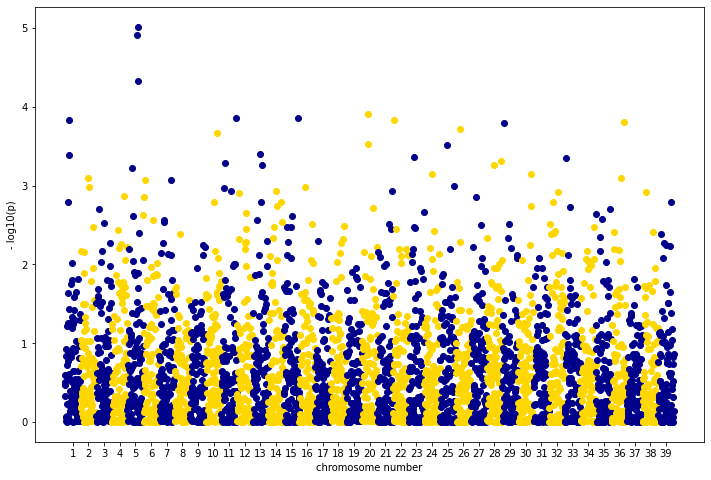

In [56]:
cur_chr = '1'
cur_x = []
cur_y = []
prev_start = 0
xpos = []
xlabel = []

fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(p_values)):
    
    chrm = (list(snp_data.columns)[i]).split(':')[0]
    
    if chrm != cur_chr:
        clr = 'gold' if int(cur_chr)%2 == 0 else 'darkblue'
        ax.plot(cur_x,cur_y, marker='o',linestyle='',color=clr)
        xpos.append(int((prev_start+i)/2))
        xlabel.append(cur_chr)
        cur_chr = chrm
        cur_x = []
        cur_y = []
        prev_start = i

    cur_x.append(i)
    cur_y.append(-np.log10(p_values[i]))

clr = 'gold' if int(cur_chr)%2 == 0 else 'darkblue'
ax.plot(cur_x,cur_y, marker='o',linestyle='',color=clr)
xpos.append(int((prev_start+i)/2))
xlabel.append(cur_chr)
plt.xticks(xpos, xlabel)
plt.xlabel('chromosome number')
plt.ylabel('- log10(p)')
plt.show()    

Notice that there are multiple SNPs in chromosome 5 and they are close to each other.
In fact, these SNPs are on the MC1R gene (https://www.ncbi.nlm.nih.gov/gene/489652), which plays a role in skin/fur pigmentation.